In [1]:
import numpy as np
import matplotlib.pyplot as plt
import energyflow as ef
import energyflow.archs
from energyflow.archs import PFN
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Layer, concatenate, ReLU
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import BatchNormalization
from scipy.stats import norm
from scipy.stats import zscore
from keras import backend

plt.rc('font', size=20)
plt.rcParams["font.family"] = "serif"


In [2]:
datasets = {'Pythia26': ef.zjets_delphes.load('Pythia26', num_data=1000000),
            'Herwig': ef.zjets_delphes.load('Herwig', num_data=1000000)}

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [3]:
w_true = datasets['Pythia26']['gen_widths']
w_reco = datasets['Pythia26']['sim_widths']
w_true_alt = datasets['Herwig']['gen_widths']
w_reco_alt = datasets['Herwig']['sim_widths']

In [11]:
initializer = tf.keras.initializers.RandomUniform(minval=-5., maxval=5.)

class MyLayer(Layer):

    def __init__(self, myc, **kwargs):
        self.myinit = myc
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self._lambda0 = self.add_weight(name='lambda0', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        self._lambda1 = self.add_weight(name='lambda1', 
                                    shape=(1,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        #return tf.exp(self._lambda1 * x + self._lambda0)
        return tf.exp(self._lambda0 * x + self._lambda1 * x**2)

myc = 0.1
mymodel_inputtest = Input(shape=(1,))
mymodel_test = MyLayer(myc)(mymodel_inputtest)
model_generator = Model(mymodel_inputtest, mymodel_test)

inputs_disc = Input((1, ))
hidden_layer_1_disc = Dense(50, activation='relu')(inputs_disc)
hidden_layer_2_disc = Dense(50, activation='relu')(hidden_layer_1_disc)
hidden_layer_3_disc = Dense(50, activation='relu')(hidden_layer_2_disc)
outputs_disc = Dense(1, activation='sigmoid')(hidden_layer_3_disc)
model_discrimantor = Model(inputs=inputs_disc, outputs=outputs_disc)

def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred)/weights_1 +
                         (1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)

model_discrimantor.compile(loss=weighted_binary_crossentropy, optimizer='adam')


# clip model weights to a given hypercube
class ClipConstraint(tf.keras.constraints.Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

const = ClipConstraint(0.01)

def weighted_binary_crossentropy_GAN(y_true, y_pred):
    weights = tf.gather(y_pred, [1], axis=1) # event weights
    y_pred = tf.gather(y_pred, [0], axis=1) # actual y_pred for loss
    
    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)
    
    #tf.print("weights",weights_0,weights_1)
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = weights * ((1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)

def weighted_binary_W_GAN(y_true, y_pred):
    weights = tf.gather(y_pred, [1], axis=1) # event weights
    y_pred = tf.gather(y_pred, [0], axis=1) # actual y_pred for loss
    
    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)
    
    #tf.print("weights",weights_0,weights_1)
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = backend.mean(weights *y_true * y_pred)
    return K.mean(t_loss)
    
model_discrimantor.trainable = False
mymodel_gan = Input(shape=(1,))
gan_model = Model(inputs=mymodel_gan,outputs=concatenate([model_discrimantor(mymodel_gan),model_generator(mymodel_gan)]))

gan_model.compile(loss=weighted_binary_crossentropy_GAN, optimizer='adam')

In [13]:
mymodel_inputtest_unifold = Input(shape=(1,))
hidden_layer_1_unifold = Dense(50, activation='ReLU',use_bias=True)(mymodel_inputtest_unifold)
batch_norm_1_unifold = BatchNormalization()(hidden_layer_1_unifold)
hidden_layer_2_unifold = Dense(50, activation='ReLU',use_bias=True)(batch_norm_1_unifold)
batch_norm_2_unifold = BatchNormalization()(hidden_layer_2_unifold)
hidden_layer_3_unifold = Dense(50, activation='ReLU',use_bias=True)(batch_norm_2_unifold)
outputs_unifold = Dense(1, activation='sigmoid',use_bias=True)(hidden_layer_3_unifold) #tanh
model_generator_unifold = Model(mymodel_inputtest_unifold, outputs_unifold)

inputs_disc_unifold = Input((1, ))
hidden_layer_1_disc_unifold = Dense(50, activation='LeakyReLU', kernel_constraint=const)(inputs_disc_unifold)
batch_norm_1_disc_unifold = BatchNormalization()(hidden_layer_1_disc_unifold)
hidden_layer_2_disc_unifold = Dense(50, activation='LeakyReLU', kernel_constraint=const)(batch_norm_1_disc_unifold)
batch_norm_2_disc_unifold = BatchNormalization()(hidden_layer_2_disc_unifold)
hidden_layer_3_disc_unifold = Dense(50, activation='LeakyReLU', kernel_constraint=const)(batch_norm_2_disc_unifold)
outputs_disc_unifold = Dense(1, activation='linear')(hidden_layer_3_disc_unifold)
model_discrimantor_unifold = Model(inputs=inputs_disc_unifold, outputs=outputs_disc_unifold)

opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

model_discrimantor_unifold.compile(loss=weighted_binary_crossentropy, optimizer=opt)
    
model_discrimantor_unifold.trainable = False
mymodel_gan_unifold = Input(shape=(1,))
gan_model_unifold = Model(inputs=mymodel_gan_unifold,outputs=concatenate([model_discrimantor_unifold(mymodel_gan_unifold),model_generator_unifold(mymodel_gan_unifold)]))

gan_model_unifold.compile(loss=weighted_binary_W_GAN, optimizer=opt)

In [14]:
xvals_1 = np.concatenate([w_true_alt,w_true])
yvals_1 = np.concatenate([np.ones(len(w_true_alt)),np.zeros(len(w_true))])


n_epochs = 3
n_batch = 128*10
n_batches = len(X_train_1) // n_batch
n_critic = 5

for i in range(n_epochs):
    mypreds = model_generator_unifold.predict(X_test_1,batch_size=1000)
    print("on epoch=",i,np.mean(mypreds),np.min(mypreds),np.max(mypreds))
    for j in range(n_batches):
        
        for _ in range(n_critic):
            X_std = (xvals_1 - xvals_1.min(axis=0)) / (xvals_1.max(axis=0) - xvals_1.min(axis=0))
            xvals_1 = X_std * (np.max(xvals_1) - np.min(xvals_1)) + np.min(xvals_1)

            X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)
            X_batch = X_train_1[j*n_batch:(j+1)*n_batch]
            Y_batch = Y_train_1[j*n_batch:(j+1)*n_batch]
            W_batch = model_generator_unifold(X_batch)
            W_batch = np.array(W_batch).flatten()
            W_batch[Y_batch==1] = 1
            #W_batch[Y_batch==0] = 1

            mypreds = model_generator_unifold.predict(X_batch,batch_size=1000)
            #print("     on batch=",j,np.mean(mypreds),np.min(mypreds),np.max(mypreds))

            Y_batch_2 = np.stack((Y_batch, W_batch), axis=1)
            model_discrimantor_unifold.train_on_batch(X_batch, Y_batch_2)
        
        gan_model_unifold.train_on_batch(X_batch[Y_batch==0],np.zeros(len(X_batch[Y_batch==0])))

on epoch= 0 0.50319606 0.5 0.51581293
on epoch= 1 0.46570846 0.34484267 0.54838043
on epoch= 2 0.4653422 0.3431683 0.5477875


KeyboardInterrupt: 

In [15]:
mypreds = model_generator_unifold.predict(X_test_1,batch_size=1000)

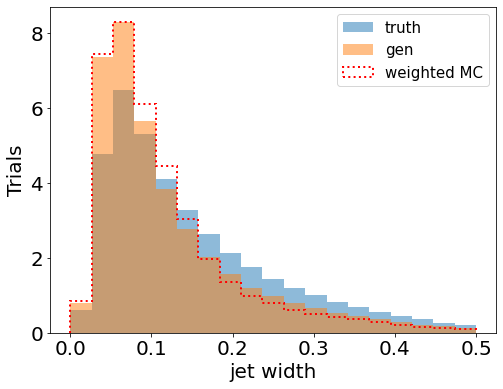

In [21]:
#bins = np.linspace(0,1,30)
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.linspace(0,0.5,20)
_,_,_=plt.hist(X_test_1[Y_test_1==1],bins=bins,alpha=0.5,label="truth",density=True, zorder=-1)
_,_,_=plt.hist(X_test_1[Y_test_1==0],bins=bins,alpha=0.5,label="gen",density=True, zorder=0)
_,_,_=plt.hist(X_test_1[Y_test_1==0],bins=bins,weights=mypreds[Y_test_1==0],histtype="step",color="red",ls=":", lw=2,label="weighted MC",density=True, zorder=1)
plt.legend(fontsize=15)
plt.ylabel("Trials")
plt.xlabel("jet width")
#plt.savefig("Unifold.pdf", bbox_inches='tight', transparent=True)
plt.show()

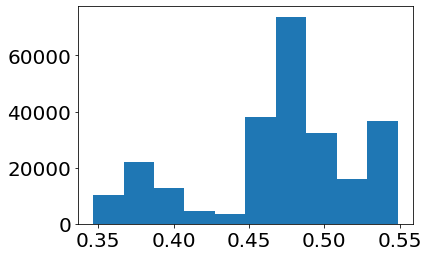

In [18]:
plt.hist(mypreds[Y_test_1==0])
plt.show()